Reviewers have highlighted the fact that jittering processing stages could lead to generalization across time, especially in later stages.

We ackowledge this issue, already mentionned in King & Dehaene (TICS 2014) and provide additional analyses to test its extent in the present dataset.

In [1]:
%matplotlib inline
import os
os.chdir('/media/DATA/Pro/Projects/Paris/Orientation/Niccolo/Paris_orientation-decoding')

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mne.decoding import GeneralizationAcrossTime
from jr.gat import scorer_auc
from base import load_epochs_events, resample_epochs, decim
from config import paths, subjects, preproc, analyses
# Select target presence analysis: strongest SNR
analysis = [ii for ii in analyses if ii['name'] == 'target_present'][0]

# Simulations

In [3]:
n_trial, n_chan, n_time, n_subject, sfreq = 100, 20, 50, 1, 256.

def simulate_source(n_source):
    """Set a random topography for each time point"""
    return np.random.randn(n_chan, n_source)

def simulate_dynamics(sources, n_source=50, latency=.010, jitter=0., onset=.020, snr=.5):
    """Simulate source response with jittering"""
    # sensor data
    n_chan, n_source = sources.shape
    X = np.zeros((n_trial, n_chan, n_time))

    # deal with variable source latencies and snr
    latency = [latency] * n_source if isinstance(latency, float) else latency
    snr = [snr] * n_source if isinstance(snr, float) else snr

    for trial in range(n_trial):
        # cumulative jitter across time
        jitters = jitter * sfreq * np.arange(n_source) * np.random.randn()

        # response start for each source in case of no jitter
        starts = np.cumsum(latency) * sfreq
        starts = np.array(starts + jitters, dtype=int)

        # source activity: 0 until start+jitter, and lasts for latency samples.
        activity = np.zeros((n_source, n_time))
        for ii, (source, this_start, this_latency, this_snr) in enumerate(zip(
                    sources, starts, latency, snr)):
            # add onset to avoid start to ensure baseline
            this_start += onset * sfreq
            
            # set source latency
            sl = slice(this_start, this_start + this_latency * sfreq + 1)
            
            # set source strength
            activity[ii, sl] = this_snr

        # Sensor activity: channel mixture of sources
        X[trial, :, :] = np.dot(sources, activity)
    return X

def simulate_data(n_source=50, latency=50, jitter=0, snr=.5):
    """Simulation pipeline for a given subject"""
    from mne import EpochsArray, create_info

    # Simulate dynamics
    sources = simulate_source(n_source)
    X = simulate_dynamics(sources, latency=latency, jitter=jitter, snr=snr)
    
    # simulate differential response in categorical conditions
    y = np.random.randint(0, 2, n_trial)
    events = np.zeros((n_trial, 3), int)
    events[:, 2] = y
    X[y==1, :, :] *= -1

    # add noise
    X += np.random.randn(*X.shape)

    # format to mne epochs
    info = create_info(ch_names=n_chan, sfreq=sfreq, ch_types='mag')
    
    return EpochsArray(data=X, events=events, info=info), y

/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.


The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
joblib supports memapping pool but "MNE_CACHE_DIR" is not set in MNE-Python config. To enable it, use, e.g., mne.set_cache_dir('/tmp/shm'). This will store temporary files under /dev/shm and can result in large memory savings.
joblib supports memapping pool but "MNE_CACHE_DIR" is not set in MNE-Python config. To enable it, use, e.g., mne.set_cache_dir('/tmp/shm'). This will store temporary files under /dev/shm and can result in large memory savings.


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished


joblib supports memapping pool but "MNE_CACHE_DIR" is not set in MNE-Python config. To enable it, use, e.g., mne.set_cache_dir('/tmp/shm'). This will store temporary files under /dev/shm and can result in large memory savings.


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished


The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
joblib supports memapping pool but "MNE_CACHE_DIR" is not set in MNE-Python config. To enable it, use, e.g., mne.set_cache_dir('/tmp/shm'). This will store temporary files under /dev/shm and can result in large memory savings.


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


joblib supports memapping pool but "MNE_CACHE_DIR" is not set in MNE-Python config. To enable it, use, e.g., mne.set_cache_dir('/tmp/shm'). This will store temporary files under /dev/shm and can result in large memory savings.


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished


joblib supports memapping pool but "MNE_CACHE_DIR" is not set in MNE-Python config. To enable it, use, e.g., mne.set_cache_dir('/tmp/shm'). This will store temporary files under /dev/shm and can result in large memory savings.


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.2s finished


The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
joblib supports memapping pool but "MNE_CACHE_DIR" is not set in MNE-Python config. To enable it, use, e.g., mne.set_cache_dir('/tmp/shm'). This will store temporary files under /dev/shm and can result in large memory savings.


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


joblib supports memapping pool but "MNE_CACHE_DIR" is not set in MNE-Python config. To enable it, use, e.g., mne.set_cache_dir('/tmp/shm'). This will store temporary files under /dev/shm and can result in large memory savings.


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished


joblib supports memapping pool but "MNE_CACHE_DIR" is not set in MNE-Python config. To enable it, use, e.g., mne.set_cache_dir('/tmp/shm'). This will store temporary files under /dev/shm and can result in large memory savings.


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished


The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
joblib supports memapping pool but "MNE_CACHE_DIR" is not set in MNE-Python config. To enable it, use, e.g., mne.set_cache_dir('/tmp/shm'). This will store temporary files under /dev/shm and can result in large memory savings.


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


joblib supports memapping pool but "MNE_CACHE_DIR" is not set in MNE-Python config. To enable it, use, e.g., mne.set_cache_dir('/tmp/shm'). This will store temporary files under /dev/shm and can result in large memory savings.


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished


joblib supports memapping pool but "MNE_CACHE_DIR" is not set in MNE-Python config. To enable it, use, e.g., mne.set_cache_dir('/tmp/shm'). This will store temporary files under /dev/shm and can result in large memory savings.


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


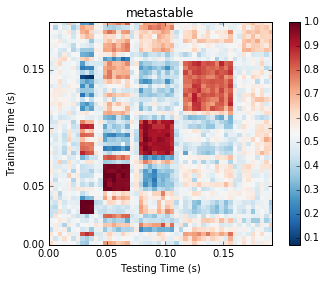

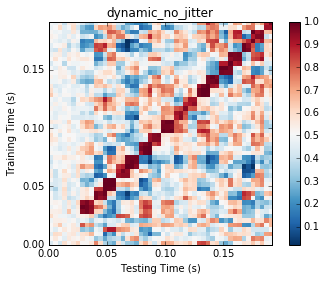

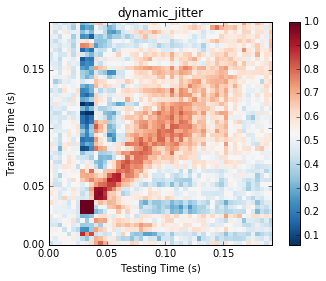

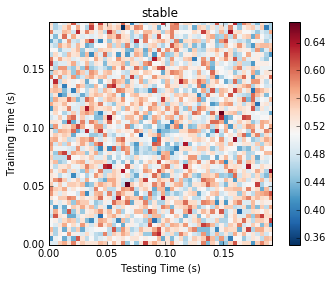

In [16]:
# example of simulations
scenari = dict(
    stable=dict(n_source=1, latency=.500, jitter=0.),
    dynamic_no_jitter=dict(n_source=50, latency=.01, jitter=0.),
    dynamic_jitter=dict(n_source=50, latency=.01, jitter=.0025),
    metastable=dict(n_source=50, jitter=.0,
                    latency=np.linspace(.01, .50, 50),
                    snr=np.r_[np.linspace(.5, .1, 5), [0] * 45])
)

for name, params in scenari.iteritems():
    epochs, y = simulate_data(**params)
    gat = GeneralizationAcrossTime(n_jobs=-1)
    gat.fit(epochs, y)
    gat.score(epochs, y)
    fig = gat.plot(show=False, title=name)


# FFT of GAT

In [30]:
def gat_fft(gat):
    from mne.time_frequency import psd_welch
    from mne import EpochsArray, create_info
    # Transform GAT into epochs
    y_pred = np.transpose(gat.y_pred_[..., 0], [2, 0, 1])  # trial, Train, test
    info = create_info(y_pred.shape[1], sfreq, 'mag')
    epochs = EpochsArray(y_pred, info=info)
    # frequency
    psds, freqs = psd_welch(epochs, n_jobs=-1)
    # put back in gat
    gat.y_pred_ = np.transpose(psds, [1, 2, 0])[..., np.newaxis]  # Train, test, trial
    gat.test_times_['times'] = [freqs] * len(gat.y_pred_)
    return gat

epochs, y = simulate_data(**scenari['dynamic_no_jitter'])
gat = GeneralizationAcrossTime(predict_method='predict_proba',
                                scorer=scorer_auc, n_jobs=-1)
gat.fit(epochs, y)
gat.predict(epochs)
gat.score(y=y)
gat = gat_fft(gat)
score = gat.score(y=y)

/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.


The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
joblib supports memapping pool but "MNE_CACHE_DIR" is not set in MNE-Python config. To enable it, use, e.g., mne.set_cache_dir('/tmp/shm'). This will store temporary files under /dev/shm and can result in large memory savings.
joblib supports memapping pool but "MNE_CACHE_DIR" is not set in MNE-Python config. To enable it, use, e.g., mne.set_cache_dir('/tmp/shm'). This will store temporary files under /dev/shm and can result in large memory savings.


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished


joblib supports memapping pool but "MNE_CACHE_DIR" is not set in MNE-Python config. To enable it, use, e.g., mne.set_cache_dir('/tmp/shm'). This will store temporary files under /dev/shm and can result in large memory savings.


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished


100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Effective window size : 0.195 (s)
joblib supports memapping pool but "MNE_CACHE_DIR" is not set in MNE-Python config. To enable it, use, e.g., mne.set_cache_dir('/tmp/shm'). This will store temporary files under /dev/shm and can result in large memory savings.


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished


joblib supports memapping pool but "MNE_CACHE_DIR" is not set in MNE-Python config. To enable it, use, e.g., mne.set_cache_dir('/tmp/shm'). This will store temporary files under /dev/shm and can result in large memory savings.


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


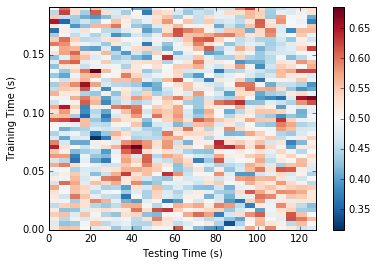

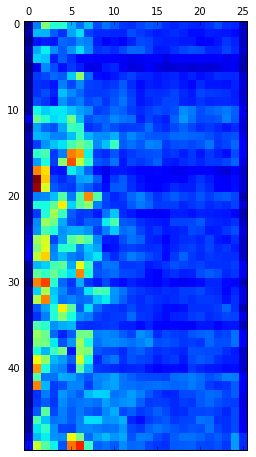

In [31]:
gat.plot(show=False)
plt.gca().set_aspect('auto')
plt.matshow(np.mean(gat.y_pred_, axis=2).squeeze())

/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.


0
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   3 out of   4 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s

1
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s

2
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   6 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s

3
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s

4
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   3 out of   4 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   6 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   7 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s

5
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   5 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

6
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   5 | elapsed:    0.3s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

7
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

8
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

9
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s

10
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    2.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

11
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

12
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s

13
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    2.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s

14
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s

15
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s

16
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s

0
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

1
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s

2
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    2.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   5 | elapsed:    0.4s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.5s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s

3
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

4
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

5
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

6
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s

7
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.5s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s

8
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s

9
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

10
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s

11
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s

12
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s

13
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   6 | elapsed:    0.3s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

14
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   3 out of   4 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s

15
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s

16
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    2.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s

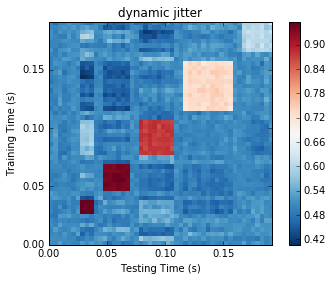

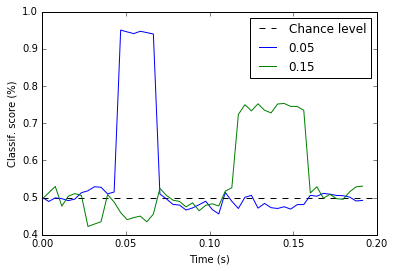

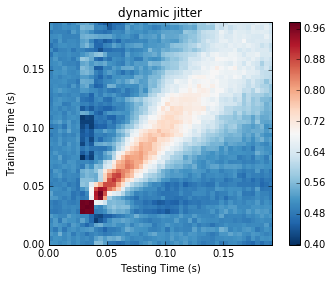

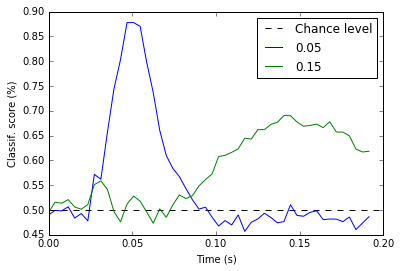

In [30]:
# Example across multiple subjects
scenari = dict(
    jitter=dict(latency=.01, jitter=.0025),
    metastable=dict(jitter=.0,
                    latency=np.linspace(.01, .50, 50),
                    snr=np.r_[np.linspace(.5, .1, 5), [0] * 45])
)
for name, params in scenari.iteritems():
    scores = list()
    for subject in range(17):
        print subject
        epochs, y = simulate_data(**params)
        gat = GeneralizationAcrossTime(n_jobs=-1)
        gat.fit(epochs, y)
        score = gat.score(epochs, y)
        scores.append(score)
    gat.scores_ = np.mean(scores, axis=0)
    gat.plot(show=False, title='dynamic jitter')
    gat.plot_times([.050, .150], show=False, chance=.5)
plt.show()

# GAT on derivative

/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.


0
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   7 | elapsed:    0.3s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

1
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

2
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s

3
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s

4
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   3 out of   4 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   6 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s

5
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   6 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s

6
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.5s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s

7
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

8
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s

9
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   6 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s

10
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s

11
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.5s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

12
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   7 | elapsed:    0.3s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

13
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.3s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

14
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.7s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s remaining:    3.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

15
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   6 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   7 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s

16
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   7 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s

0
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    2.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

1
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   5 out of   7 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s

2
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

3
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s

4
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

5
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s remaining:    3.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

6
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

7
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.5s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

8
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

9
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s remaining:    3.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

10
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.5s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

11
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s remaining:    3.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

12
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.6s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

13
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.5s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.3s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

14
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s

15
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   6 | elapsed:    0.3s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.6s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.3s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

16
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.4s remaining:    2.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.6s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s remaining:    3.7s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

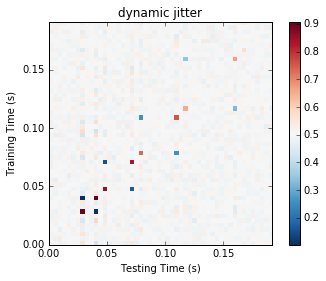

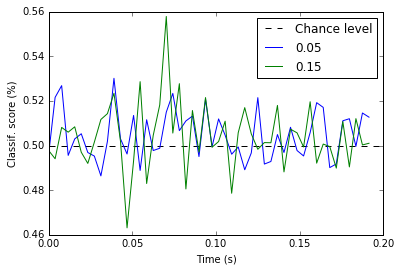

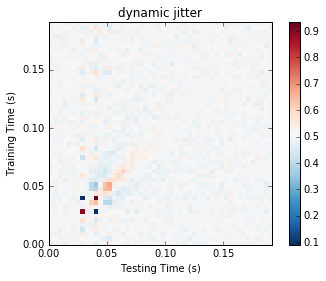

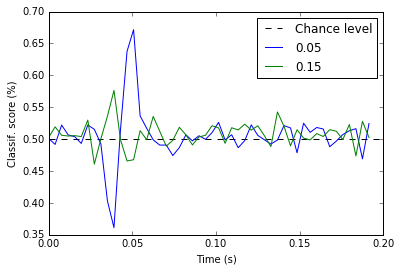

In [31]:
# Example across multiple subjects
scenari = dict(
    jitter=dict(latency=.01, jitter=.0025),
    metastable=dict(jitter=.0,
                    latency=np.linspace(.01, .50, 50),
                    snr=np.r_[np.linspace(.5, .1, 5), [0] * 45])
)
for name, params in scenari.iteritems():
    scores = list()
    for subject in range(17):
        print subject
        epochs, y = simulate_data(**params)
        epochs._data[:, :, 1:] = epochs._data[:, :, 1:] - epochs._data[:, :, :-1]
        gat = GeneralizationAcrossTime(n_jobs=-1)
        gat.fit(epochs, y)
        score = gat.score(epochs, y)
        scores.append(score)
    gat.scores_ = np.mean(scores, axis=0)
    gat.plot(show=False, title='dynamic jitter')
    gat.plot_times([.050, .150], show=False, chance=.5)
plt.show()

# Trying to filter

In [24]:
# Main pipeline

def gat_scores(epochs, y, freqs=[None, None]):
    from mne.filter import band_pass_filter, high_pass_filter, low_pass_filter
        
    # Filter data
    if freqs[0] is not None and freqs[1] is not None:
        epochs._data = band_pass_filter(
            epochs._data, Fs=epochs.info['sfreq'],
            Fp0=freqs[0], Fp1=freqs[1])
    elif freqs[0] is None and freqs[1] is not None:
        epochs._data = low_pass_filter(
            epochs._data, Fs=epochs.info['sfreq'],
            Fp=freqs[1])
    elif freqs[1] is None and freqs[0] is not None:
        epochs._data = high_pass_filter(
            epochs._data, Fs=epochs.info['sfreq'],
            Fp=freqs[0])
    
    # Downsample for speed purposes
    epochs.decimate(3, copy=False)
    
    # Apply analysis
    gat = GeneralizationAcrossTime(clf=analysis['clf'],
                                   cv=analysis['cv'],
                                   scorer=analysis['scorer'],
                                   n_jobs=-1)
    gat.fit(epochs, y)
    scores = gat.score(epochs, y)
    
    return gat

def quantify_metastability():
    # XXX todo
    pass

/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.


0
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.


/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: Attenuation at stop frequency 10.5Hz is only 5.2dB.
/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s

1
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

2
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   5 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

3
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   5 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.5s

4
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   6 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

5
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

6
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

7
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

8
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

9
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   4 out of   6 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.6s

10
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

11
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

12
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   6 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s

13
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

14
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   6 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

15
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

16
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

Cannot find chance level from scorer_auc, specify chance level
0
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: Cannot find chance level from scorer_auc, specify chance level
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s rema

1
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   6 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

2
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   7 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

3
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

4
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   6 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

5
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.7s

6
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    1.8s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.6s

7
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   5 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

8
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   5 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

9
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

10
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

11
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   3 out of   4 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

12
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

13
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

14
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

15
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   6 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

16
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 10.5Hz is only 5.2dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.1s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.0s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

Cannot find chance level from scorer_auc, specify chance level


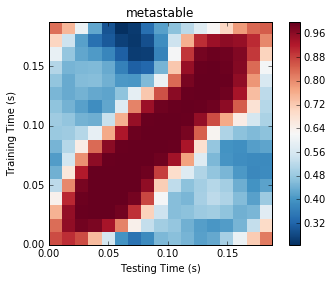

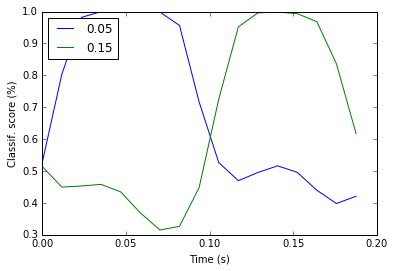

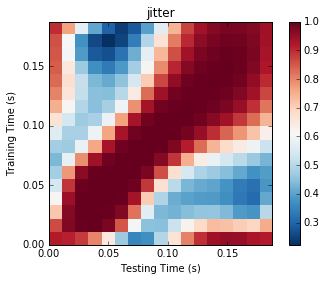

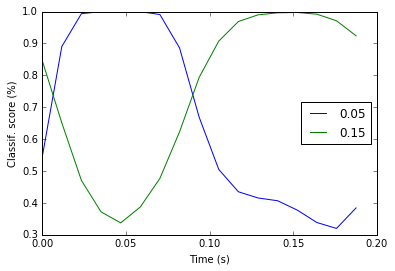

In [27]:
# Example across multiple subjects
scenari = dict(
    jitter=dict(latency=.01, jitter=.0025),
    metastable=dict(jitter=.0,
                    latency=np.linspace(.01, .50, 50),
                    snr=np.r_[np.linspace(.5, .1, 5), [0] * 45])
)
for name, params in scenari.iteritems():
    scores = list()
    for subject in range(17):
        print subject
        epochs, y = simulate_data(**params)
        gat = gat_scores(epochs, y, [None, 10.])
        scores.append(gat.scores_)
    gat.scores_ = np.mean(scores, axis=0)
    gat.plot(show=False, title=name)
    gat.plot_times([.050, .150], show=False)

In [29]:
plt.show()

/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.


0
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.


/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: Attenuation at stop frequency 9.5Hz is only 5.1dB.
/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

1
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s

2
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   6 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

3
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

4
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   6 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

5
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

6
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

7
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   5 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

8
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

9
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

10
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

11
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

12
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

13
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

14
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

15
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   5 | elapsed:    0.2s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.8s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

16
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

Cannot find chance level from scorer_auc, specify chance level
0
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: Cannot find chance level from scorer_auc, specify chance level
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s rema

1
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   3 out of   4 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   6 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

2
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s

3
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

4
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

5
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

6
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   3 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s

7
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   5 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

8
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   5 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

9
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

10
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s

11
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.7s

12
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

13
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s

14
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s

15
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

16
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Attenuation at stop frequency 9.5Hz is only 5.1dB.
The measurement information indicates a low-pass frequency of 128 Hz. The decim=3 parameter will result in a sampling frequency of 85.3333 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Done   1 out of   2 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.6s

Cannot find chance level from scorer_auc, specify chance level


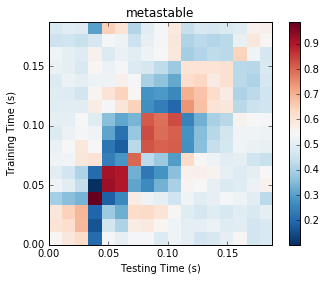

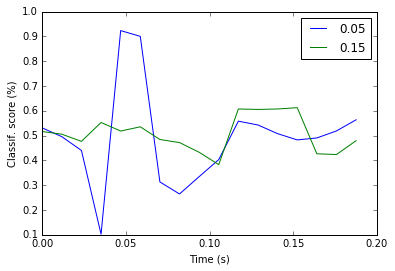

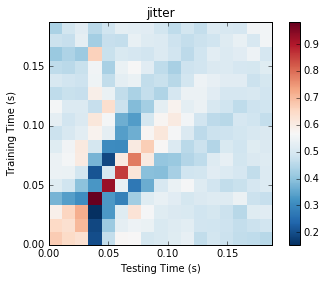

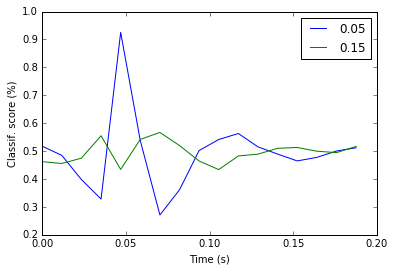

In [32]:
# Example across multiple subjects
scenari = dict(
    jitter=dict(latency=.01, jitter=.0025),
    metastable=dict(jitter=.0,
                    latency=np.linspace(.01, .50, 50),
                    snr=np.r_[np.linspace(.5, .1, 5), [0] * 45])
)
for name, params in scenari.iteritems():
    scores = list()
    for subject in range(17):
        print subject
        epochs, y = simulate_data(**params)
        gat = gat_scores(epochs, y, [10., None])
        scores.append(gat.scores_)
    gat.scores_ = np.mean(scores, axis=0)
    gat.plot(show=False, title=name)
    gat.plot_times([.050, .150], show=False)

# Sorting individual trials

In [84]:
def prob_gat_y_pred(gat):
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    y_pred = np.transpose(gat.y_pred_[:, :, :, 0], [2, 0, 1])
    clf = LogisticRegression()
    n_time = y_pred.shape[1]
    for T in range(n_time):
        for t in range(n_time):
            for train, test in gat._cv_splits:
                clf.fit(y_pred[train, T, t][:, None], y=y[train])
                this_y_pred = clf.predict_proba(y_pred[test, T, t][:, None])
                y_pred[test, T, t] = this_y_pred[:, 1]  # Log. Reg inverted proba
    return y_pred.transpose([1, 2, 0])

In [153]:
from jr.gat import scorer_auc
if False:  # jitter etc
    epochs, y = simulate_data(jitter=.0,
                              latency=np.linspace(.01, .50, 50),
                              snr=np.r_[np.linspace(.5, .1, 5), [0] * 45])
epochs, y = simulate_data(n_source=50, latency=.01, jitter=0.)

gat = GeneralizationAcrossTime(n_jobs=-1, predict_method='predict_proba', 
                               scorer=scorer_auc)
gat.fit(epochs, y)
gat.predict(epochs)
y_pred = prob_gat_y_pred(gat)
y_true = y[np.newaxis, np.newaxis, :]
y_score = (1 - y_true) + (y_true * 2 - 1) * y_pred

/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.


The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.2s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=8)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.7s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   5 out of   7 | elapsed:    1.0s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.2s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished


[ 0.88574671  7.4998969   2.61550964]


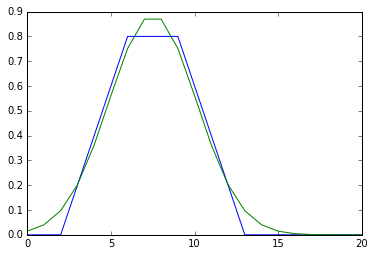

In [195]:
def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2. * sigma ** 2))

def fit_gauss(y, mean0=None):
    from scipy.optimize import curve_fit
    n = len(y)
    mean0 = np.round(np.random.rand() * n) # if mean0 is None else mean0
    x = np.arange(n)
    try:
        coefs, _ = curve_fit(gauss, x, y, p0=[1., mean0, 1.],
                             bounds=[[-1., 0., 1], [1., n, 2*n]])
    except Exception:
        print("error: didn't converge")
        coefs = [0, 0, 0]

    return coefs

# Define some test data which is close to Gaussian
y = np.array([0, 0, 0,1,2,3,4,4,4,4,3,2,1, 0, 0, 0, 0, 0, 0, 0, 0]) / 5.
coefs = fit_gauss(y)
print coefs

plt.plot(y, label='Test data')
plt.plot(gauss(np.arange(len(y)), *coefs), label='Fitted data')
plt.show()

In [169]:
# fit gaussian on every trial

def trial_fit(X, n_jobs=-1):
    from mne.parallel import parallel_func
    n_train, n_test, n_trial = X.shape
    parallel, p_func, n_jobs = parallel_func(_trial_fit, n_jobs)
    n_chunks = min(n_train, n_jobs)
    chunks = np.array_split(X, n_chunks, axis=0)

    out = parallel(p_func(chunk) for chunk in chunks)

    y_pred = np.concatenate([ii[0] for ii in out], axis=0)
    coefs = np.concatenate([ii[1] for ii in out], axis=0)
    return y_pred, coefs

def _trial_fit(X):
    n_train, n_test, n_trial = X.shape
    y_pred = np.zeros_like(X)
    coefs = np.zeros((n_train, n_trial, 3))
    for train in range(n_train):
        for trial in range(n_trial):
            coef = fit_gauss(X[train, :, trial], mean0=train)
            y_pred[train, :, trial] = gauss(np.arange(n_test), *coef)
            coefs[train, trial, :] = coef
    return y_pred, coefs

chance = .5 # only valid for 2 class balanced problem
y_pred_, coefs = trial_fit(y_pred - chance)

[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.3min remaining:   26.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.3min remaining:  1.3min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.4min remaining:  4.1min
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:  1.4min remaining:  9.8min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.4min finished
/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app
/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


error: didn't converge


[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    2.7s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.2s remaining:    9.5s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    3.2s remaining:   22.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.2s finished


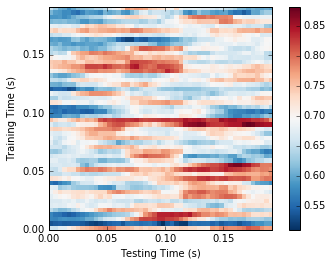

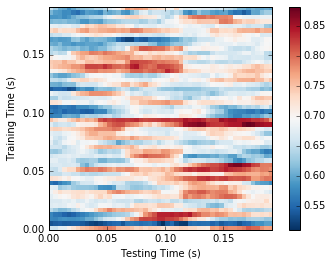

In [170]:
gat.y_pred_ = y_pred_

gat.score()
gat.plot()

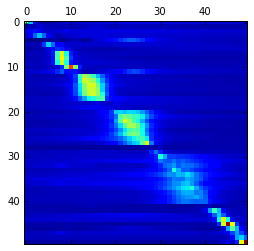

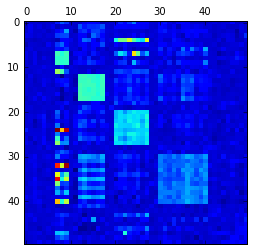

In [102]:
plt.matshow(y_score_fit.mean(axis=2))
plt.matshow(y_score.mean(axis=2))

In [ ]:
# sort
# train of first half
# test on second half

# Time frequency decoding

# Deadend: XDawn

Trying to isolate a single source is a dead end

/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.


The events passed to the Epochs constructor are not chronologically ordered.
100 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.3s remaining:    2.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   3 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:    0.5s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    2.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    2.7s

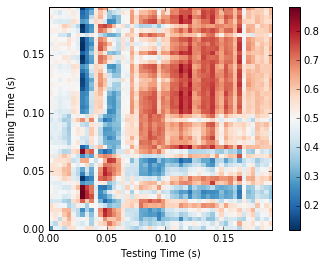

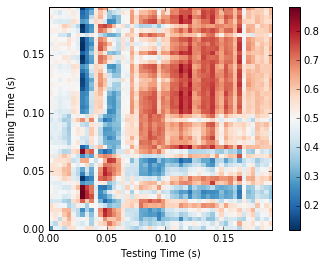

In [58]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from jr.gat import rescale_ypred
from mne.preprocessing import Xdawn
from mne.decoding import EpochsVectorizer

epochs, y = simulate_data(n_source=50, latency=.01, jitter=.0025)
epochs_late = epochs.copy()
epochs_late.crop(.100, None)

# cross-validated Xdawn on late components
cv = StratifiedKFold(n_folds=5)
preds = np.empty((epochs._data.shape[0], 2, epochs._data.shape[2]))
for train, test in cv.split(y, y):
    trans = Xdawn(n_components=1)  # n_components is * 2
    trans.fit(epochs_late[train], y[train])
    preds[test, :, :] = trans.transform(epochs[test])

epochs._data *= 0
epochs._data[:, :2, :] = preds

from jr.gat import scorer_auc
gat = GeneralizationAcrossTime(predict_method='predict_proba', scorer=scorer_auc, n_jobs=-1)
gat.fit(epochs, y)
scores = gat.score(epochs, -y)
gat.plot()

(100, 50)


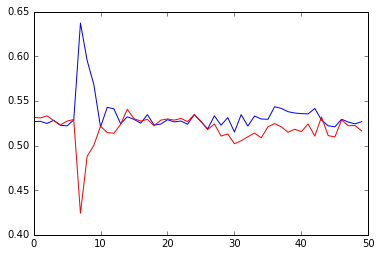

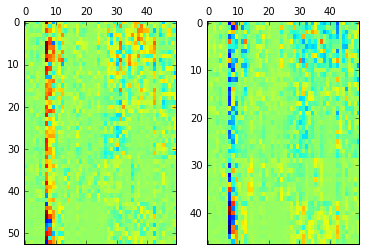

In [59]:
from jr.plot import share_clim
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
tmax = np.argmax(np.diag(scores))
y_pred = gat.y_pred_[tmax, :, :, 0].T
clf = LogisticRegression()
n_time = y_pred.shape[1]
print(y_pred.shape)
for t in range(n_time):
    for train, test in gat._cv_splits:
        clf.fit(y_pred[train, t][:, None], y=y[train])
        y_pred[test, t] = clf.predict_proba(y_pred[test, t][:, None])[:, 0]

plt.figure()
plt.plot(np.mean(y_pred[y==0, :], axis=0), color='b')
plt.plot(np.mean(y_pred[y==1, :], axis=0), color='r')

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.matshow(y_pred[y==0, :], aspect='auto')
ax2.matshow(y_pred[y==1, :], aspect='auto')
share_clim((ax1, ax2))
plt.show()

In [60]:
# plot sorted single trial
from sklearn.cluster.spectral import spectral_embedding
from sklearn.metrics.pairwise import rbf_kernel

def order_func(data):
    this_data = np.copy(data[:, slice(tmax-10, tmax+10)])
    this_data /= np.sqrt(np.sum(this_data ** 2, axis=1))[:, np.newaxis]
    return np.argsort(spectral_embedding(rbf_kernel(this_data, gamma=1.),
                      n_components=1, random_state=0).ravel())
data = (y_pred - .5) * (y[:, np.newaxis] * 2. - 1)
print(data.shape)
order = order_func(data)
plt.matshow(data[order, :])
plt.show()
print(y)

(100, 50)


ValueError: Found array with 0 feature(s) (shape=(100, 0)) while a minimum of 1 is required.

In [ ]:
# Data


def load_data(subject):
    # load data
    epochs, events = load_epochs_events(subject, paths)
    
    # remove meaningless trials
    query, condition = analysis['query'], analysis['condition']
    sel = range(len(events)) if query is None else events.query(query).index
    sel = [ii for ii in sel if ~np.isnan(events[condition][sel][ii])]
    
    # set regressor
    y = np.array(events[condition], dtype=np.float32)
    
    return epochs, 
    
        